### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템(LangGraph 사용하기)

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_cafe(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [4]:
from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

In [5]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_cafe, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.runnables.base.RunnableBinding'>


In [6]:
from langchain_core.messages import HumanMessage

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"아메리카노의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"아메리카노 가격"}',
                              'name': 'search_cafe'},
                 'id': 'call_ncHV1CP5eX1bIWRX2GTTBkAK',
                 'index': 0,
                 'type': 'function'}]}


In [7]:
# 도구 호출 ( Tavily )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"LangGraph"}',
                              'name': 'search_web'},
                 'id': 'call_x2yxRFeH1EV05hd2KLdEVTh4',
                 'index': 0,
                 'type': 'function'}]}


In [8]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{}


In [9]:
pprint(tool_call)

AIMessage(content='3 + 3은 6입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--5c3ca008-ad03-4e45-9ae0-e6a3e556d5f3-0')


In [10]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tools = [search_cafe, search_web]
tool_node = ToolNode(tools=tools)

In [11]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"아메리카노의 가격은 얼마인가요?")])

pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"아메리카노 가격"}',
                              'name': 'search_cafe'},
                 'id': 'call_gj5xqgAcVJROt7gSYfDSBCH3',
                 'index': 0,
                 'type': 'function'}]}


In [12]:
# 도구 호출 결과를 메시지로 추가하여 실행 
results = tool_node.invoke({"messages": [tool_call]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1 비율로 구성된 이탈리아 전통 커피입니다. 진한 커피 맛과 부드러운 우유 거품의 조화가 일품이며, 계피 파우더를 뿌려 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스

In [13]:
# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("LangGraph는 무엇인가요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

C:\Users\user\AppData\Local\Temp\ipykernel_17592\1013197172.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchain), is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize [large language models](https://www.ibm.com/think/topics/large-language-models) (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the [...] By using a graph-based architecture, LangGraph enables users to scale artificial intelligence workflows without slowing down or sacrificing efficiency. LangGraph uses enhanced decision-making by modeling complex relationships between nodes, which means it uses AI agents to analyze their past actions and feedback. In the world of LLMs, this process is referred to as reflection. [...] **Agent systems**: LangGraph provides a framework for

<class 'langgraph.graph.state.CompiledStateGraph'>


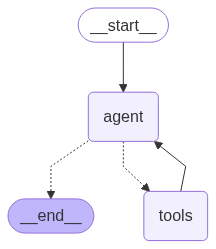

In [14]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm, 
    tools=tools, 
)

"""
[create_react_agent() 설명]
1. 역할: 
   - 'ReAct(Reasoning + Acting)' 프레임워크 기반의 자동화 에이전트 생성
   - 에이전트가 '생각(Reasoning)'과 '행동(Acting)'을 반복하며 문제 해결

2. 동작 방식:
   - 사용자 질문 → LLM이 '생각' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답
   - 이 과정을 자동으로 반복하는 그래프 구조 생성

3. 예시 시나리오:
   "오늘 서울 날씨 알려줘" 질문 시:
   1. 날씨 API 도구 사용 필요 판단
   2. 날씨 API 호출
   3. 결과 해석 후 사용자 응답 생성
"""

print(type(graph)) # <class 'langgraph.graph.StateGraph'>

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노의 가격은 얼마인가요?")]}

"""
[실행 과정]
1. inputs → 그래프 시작 노드로 전달
2. 각 노드에서 'messages' 리스트 업데이트
3. 최종 상태 반환 (모든 메시지 포함)
"""
messages = graph.invoke(inputs)

for m in messages['messages']:
    print(type(m),m)
    m.pretty_print()

<class 'langchain_core.messages.human.HumanMessage'> content='아메리카노의 가격은 얼마인가요?' additional_kwargs={} response_metadata={} id='e4282233-8c5f-4e57-9688-ac6d624113c8'
================================ Human Message =================================

아메리카노의 가격은 얼마인가요?
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MRGKZ9yBQ2kVkpUcbFnW5CxY', 'function': {'arguments': '{"query":"아메리카노 가격"}', 'name': 'search_cafe'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--04c435ac-752b-41e6-892c-68ce9b18070f-0' tool_calls=[{'name': 'search_cafe', 'args': {'query': '아메리카노 가격'}, 'id': 'call_MRGKZ9yBQ2kVkpUcbFnW5CxY', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_MRGKZ9yBQ2kVkpUcbFnW5CxY)
 Call ID: call_MRGKZ9yB

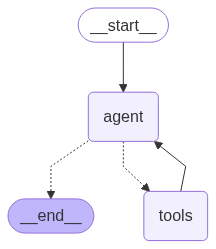

In [16]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from textwrap import dedent

# 시스템 프롬프트 (한글 버전)
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_cafe  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_cafe | 아메리카노 | ../data/cafe.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm,        # 언어 모델 (예: ChatOpenAI 인스턴스)
    tools=tools,   # 사용 가능한 도구 리스트
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),   # 시스템 프롬프트 설정 (AI의 행동 지침)
        HumanMessage(content="아메리카노의 가격은 얼마인가요?")  # 사용자 질문
    ]
#inputs = {"messages": [HumanMessage(content="아메리카노의 가격은 얼마인가요?")]}
#messages = graph.invoke(inputs)

# 그래프 실행 (SystemMessage 포함)
messages = graph.invoke({"messages": messages})
"""
[실행 과정]
1. SystemMessage를 먼저 처리 → AI의 행동 규칙 설정
2. HumanMessage 처리 → 질문 분석 및 도구 사용 결정
3. 필요한 경우 tools 리스트의 도구들 자동 호출
4. 최종 응답 생성
"""

for m in messages['messages']:
    m.pretty_print()
    
"""
    [출력 예시]
    System: (시스템 프롬프트 내용 요약)...
    Human: 아메리카노의 가격은 얼마인가요?
    AI: [출처: cafe_db | 아메리카노 | ../db/cafe.csv] 
        아메리카노는 4,500원입니다.
    """    

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_cafe  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_cafe | 아메리카노 | ../data/cafe.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

아메리카노의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  searc

'\n    [출력 예시]\n    System: (시스템 프롬프트 내용 요약)...\n    Human: 아메리카노의 가격은 얼마인가요?\n    AI: [출처: cafe_db | 아메리카노 | ../db/cafe.csv] \n        아메리카노는 4,500원입니다.\n    '

<class 'langgraph.graph.state.CompiledStateGraph'>


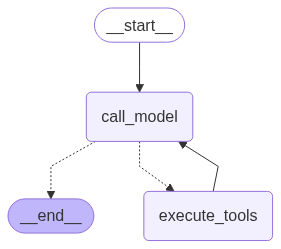

In [18]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="우유가 포함된 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

우유가 포함된 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_vyyH2PrXWA07wP93tGYpm5Xx)
 Call ID: call_vyyH2PrXWA07wP93tGYpm5Xx
  Args:
    query: 우유
================================= Tool Message =================================
Name: search_cafe

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1 비율로 구성된 이탈리아 전통 커피입니다. 진한 커피 맛과 부드러운 우유 거품의 조화가 일품이며, 계피 파우더를 뿌려 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 

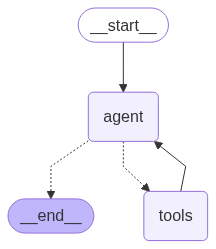

In [20]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노의 가격은 얼마인가요? 아메리카노에 어울리는 디저트는 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노의 가격은 얼마인가요? 아메리카노에 어울리는 디저트는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_F4ORjZXaiQhNKkxZ5Gjn2Lcc)
 Call ID: call_F4ORjZXaiQhNKkxZ5Gjn2Lcc
  Args:
    query: 아메리카노
  search_web (call_8SLnKVwUlkksVCQDtfOCrigA)
 Call ID: call_8SLnKVwUlkksVCQDtfOCrigA
  Args:
    query: 아메리카노에 어울리는 디저트
================================= Tool Message =================================
Name: search_cafe

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>



In [22]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

추천할 내용이 무엇인지에 대한 정보가 부족합니다. 어떤 종류의 추천을 원하시는지 구체적으로 말씀해 주시면 더 도움이 될 것입니다. 예를 들어, 음식, 카페, 책, 영화, 여행지 등 어떤 분야에서 추천이 필요한지 알려주세요.


In [23]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 기반 체크포인트 저장소 초기화
memory = MemorySaver()
"""
[MemorySaver 설명]
1. 역할:
   - 그래프 실행 상태를 메모리(RAM)에 저장하는 체크포인트 시스템
   - 실행 중단/재개 시 상태 복원 가능

2. 특징:
   - 휘발성 저장소 (프로세스 종료 시 데이터 소멸)
   - 개발/테스트 환경에 적합 (간편한 사용)
   - 작은 규모의 상태 관리에 최적화

3. 저장 내용 예시:
   - 각 노드의 출력 결과
   - 메시지 기록
   - 사용자 정의 상태 데이터
"""

"""
[체크포인트 적용 효과]
1. 실행 상태 추적:
   - graph_memory.get_state()로 현재 상태 조회 가능
   - 예: 특정 노드 실패 시 실패 지점부터 재개

2. 주요 사용 사례:
   - 장시간 실행 작업의 중간 저장
   - 디버깅 시 특정 단계 상태 검사
   - 사용자 세션 관리 (예: 채팅 기록 유지)

3. 저장 메커니즘:
   - 각 노드 실행 후 자동 상태 저장
   - key 기반으로 상태 검색 (기본값: 세션 ID)
"""
graph_memory = builder.compile(checkpointer=memory)

"""
[MemorySaver vs 영구 저장소]
1. MemorySaver (메모리):
   - 장점: 설정 간편, 빠른 접근
   - 단점: 서버 재시작 시 데이터 손실

2. FileSaver/DB 저장소:
   - 장점: 영구 보존
   - 단점: 추가 설정 필요
"""

'\n[MemorySaver vs 영구 저장소]\n1. MemorySaver (메모리):\n   - 장점: 설정 간편, 빠른 접근\n   - 단점: 서버 재시작 시 데이터 손실\n\n2. FileSaver/DB 저장소:\n   - 장점: 영구 보존\n   - 단점: 추가 설정 필요\n'

In [24]:
config = {
    "configurable": {"thread_id": "1"}  # 고유 세션 ID (사용자/채팅방 구분용)
}
"""
[config 설정 설명]
1. thread_id: 
   - 대화 세션을 구분하는 고유 키
   - 동일 ID로 실행 시 이전 상태 복원 가능
   - 예: 사용자별로 다른 ID 할당 ("user1", "user2")
"""

messages = [HumanMessage(content="아메리카노의 가격은 얼마인가요?")]
messages = graph_memory.invoke(
    {"messages": messages},     # 입력 데이터
    config                      # 체크포인트 설정
)
"""
[실행 과정]
1. thread_id "1"의 이전 상태 확인 (없으면 새 세션 시작)
2. 메시지 처리:
   - 시스템 프롬프트 자동 적용 (생략됨)
   - 도구 사용 필요 시 execute_tools 노드 호출
3. 실행 상태를 메모리에 저장 (MemorySaver)
4. 중간 실패 시 config로 재시작 가능
"""

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_4vpPmPjPFTXHPbYnF5w2nMvY)
 Call ID: call_4vpPmPjPFTXHPbYnF5w2nMvY
  Args:
    query: 아메리카노
================================= Tool Message =================================
Name: search_cafe

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1

In [25]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="그 중에 가장 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_4vpPmPjPFTXHPbYnF5w2nMvY)
 Call ID: call_4vpPmPjPFTXHPbYnF5w2nMvY
  Args:
    query: 아메리카노
================================= Tool Message =================================
Name: search_cafe

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1

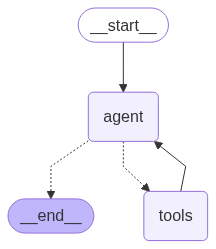

In [26]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.messages import SystemMessage

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    checkpointer=memory,
    )
# 메모리세이버는 체크포인터에 주면 된다.
# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "2"}}

#messages = [HumanMessage(content="우유가 포함된 메뉴가 있나요?")]
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="우유가 포함된 메뉴가 있나요?")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_cafe  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_cafe | 아메리카노 | ../data/cafe.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

우유가 포함된 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search

In [28]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요? 가격이 더 저렴한 메뉴는 무엇인가요?")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_cafe  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_cafe | 아메리카노 | ../data/cafe.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

우유가 포함된 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search

In [ ]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들
example_questions = [
    "우유에 알러지가 있는 사람들을 위한 메뉴를 추천해주세요.",
    "더운 여름에 어울리는 메뉴는 무엇인가요?",
    "아메리카노에 어울리는 디저트는 무엇인가요?"
]

# 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config=config)
        
        if "messages" in result:
            # 메시지 로깅 (선택사항)
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                msg.pretty_print()

            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content

        return "응답을 생성하지 못했습니다."

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = process_message(message, history, self.thread_id)
        return response

chatbot = ChatBot()


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="카페 메뉴 AI 어시스턴트",
    description="카페 메뉴 정보, 추천, 음료 및 디저트 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Thread ID: a179fef5-33e4-4cc0-ad32-74dff6ff113b
스레드 ID: a179fef5-33e4-4cc0-ad32-74dff6ff113b
================================ Human Message =================================

우유에 알러지가 있는 사람들을 위한 메뉴를 추천해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_cafe (call_rTLUxjxKK7mvXlAX1jA1Vrih)
 Call ID: call_rTLUxjxKK7mvXlAX1jA1Vrih
  Args:
    query: 우유 알러지 메뉴
================================= Tool Message =================================
Name: search_cafe

<Document source="../data/cafe_menu_data.txt"/>
4. 바닐라 라떼
   • 가격: ₩6,000
   • 주요 원료: 에스프레소, 스팀 밀크, 바닐라 시럽
   • 설명: 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_me

In [30]:
# 데모 종료
demo.close()

Closing server running on port: 7860
